Imports and check that we are uisng GPU and not CPU (necessary for faster run time)

In [1]:
import os
import splitfolders

import pandas as pd
import cv2 as cv
import hashlib
import numpy as np
import matplotlib.pyplot as plt

import shutil

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score
from PIL import Image
import random

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
df = pd.read_csv("archive/sports.csv")
df.head()

class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train

we fix (rewrite) the space to a symbol "_", and at the same time chceck which sport categories are most represented - have the most images to them (this will be necessary later on when we have to pick 10 most suitable categories)

In [3]:
#Let's get rid of the spaces in labels right away
df.labels = df.labels.str.replace(' ', '_')
#Also, let's look at how many pictures of each sport do we have
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

In [4]:
#Since we have to classify 10 classes, I think the first 10 are good enough, since those are pretty distinct ones and also, they have nearly enough images
#(Lecturer said, that for classification task, there should be around 200-400 images per class)
#Also, I'm pretty sure it's supposed to be canoe slalom, not slamon, but my laziness is unimaginable, so I'm going to let it be.

In folllowing part of out code we simply chcek for duplicates if there are any, aswell as if the given pictures have suitable image formats, if they dont we dop them. In our scenario one usch file was found with path - archive/train/high jump/159.lnk, and we have dropped this file, because we have no use for it. Finlly we chcek if the provided images have correct size (shape) - 224x224.

In [5]:
Path_to_csv = "archive/"
size = 0
duplicate = 0
dictionary = {}

for img_path in df["filepaths"]:
    img_path = Path_to_csv + img_path
    img = cv.imread(img_path)

    #detecting format
    if img is None:
        print("Image {} not found".format(img_path))
        row_to_drop = df[df["filepaths"]==img_path].index
        df.drop(row_to_drop, inplace=True)
        continue

    #checking for duplicates
    hashed_image = hashlib.md5(img).hexdigest()
    if hashed_image not in dictionary:
        dictionary[hashed_image] = img_path
    else:
        duplicate += 1

    #checking size
    height, width = img.shape[:2]
    if height != width != 244:
        size += 1

print(f"Number of exact duplicates: {duplicate}")
print(f"Number of images with incorrect size: {size}")

Image archive/train/high jump/159.lnk not found
Number of exact duplicates: 0
Number of images with incorrect size: 0


In [6]:
#We can see, that there is a one image is not image at all, so we have to drop it.
#There are no exact duplicates in the dataset
#All images have correct size
df.labels.value_counts()

labels
football              201
formula_1_racing      200
nascar_racing         199
baseball              184
hockey                182
                     ... 
horseshoe_pitching    112
arm_wrestling         109
wingsuit_flying       108
ultimate              107
sky_surfing            69
Name: count, Length: 100, dtype: int64

Here are our categories we have settled with. They are most represented ones, but also follow condition that one isnt "handicapped" version of another (there were such sports in our collection), There are combinations which can be later on problematic (nascar_racing - formula_1_racing -> they both have big part of the image similar race track with tarmac), but we will find that out at the end thanks to confusion matrix. We also update dataframe to contain only the sports we have selected.

In [7]:
#Now we will filter the dataset to classes we want to classify plus one unknown class, build from the other classes
#Unknow class size will be adjusted to match size of other classes

dataframe = df.copy()

selected = ["football", "formula_1_racing","nascar_racing","baseball","hockey","basketball","olympic_wrestling","rugby","canoe_slamon", "roller_derby"]

for index, label in dataframe['labels'].items():
    if label not in selected:
        dataframe.drop(index, inplace=True)

#We also need to update classes
dataframe.rename(columns={'class id': 'class_id'}, inplace=True)
dataframe["class_id"] = pd.Categorical(dataframe["labels"], categories=selected).codes
dataframe.head()

class_id               filepaths    labels data set
838         3  train/baseball/001.jpg  baseball    train
839         3  train/baseball/002.jpg  baseball    train
840         3  train/baseball/003.jpg  baseball    train
841         3  train/baseball/004.jpg  baseball    train
842         3  train/baseball/005.jpg  baseball    train

In [8]:
#at this point, we can drop the label and use one hot on class_id, which is basically our new label
reduced_dataframe = dataframe.copy()
reduced_dataframe.drop(["labels"], axis=1, inplace=True)
one_hot = pd.get_dummies(reduced_dataframe['class_id'])
reduced_dataframe = reduced_dataframe.drop(["class_id"], axis=1)
reduced_dataframe = one_hot.join(reduced_dataframe)
reduced_dataframe.head()

0      1      2     3      4      5      6      7      8      9  \
838  False  False  False  True  False  False  False  False  False  False   
839  False  False  False  True  False  False  False  False  False  False   
840  False  False  False  True  False  False  False  False  False  False   
841  False  False  False  True  False  False  False  False  False  False   
842  False  False  False  True  False  False  False  False  False  False   

                  filepaths data set  
838  train/baseball/001.jpg    train  
839  train/baseball/002.jpg    train  
840  train/baseball/003.jpg    train  
841  train/baseball/004.jpg    train  
842  train/baseball/005.jpg    train

In [9]:
#Now we need to split the data into train, test and validation datasets
#In this case we will try to use already prepared separation
#TODO -> if anyone will have time, we should split it by ourselves as well
test_data = reduced_dataframe[reduced_dataframe["data set"] == "test"]
test_data = test_data.drop(["data set"], axis=1)
train_data = reduced_dataframe[reduced_dataframe["data set"] == "train"]
train_data = train_data.drop(["data set"], axis=1)
validation_data = reduced_dataframe[reduced_dataframe["data set"] == "valid"]
validation_data = validation_data.drop(["data set"], axis=1)
#Now we have all the datasets split.

In [10]:
train_data.describe(include="all")

0      1      2      3      4      5      6      7      8      9  \
count    1745   1745   1745   1745   1745   1745   1745   1745   1745   1745   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq     1554   1555   1556   1571   1573   1576   1578   1579   1581   1582   

                  filepaths  
count                  1745  
unique                 1745  
top     train/rugby/166.jpg  
freq                      1

5 rows × 150540 columns

Here we load every image from the training dataset and create two separate versions of it so we can later compare the effect of normalization. First, we load the image in its original form, only converting it to RGB and resizing it, which gives us the unnormalized version where all pixel values stay unchanged in the range 0–255. Then we load the same image again, but this time we divide every pixel value by 255. Since each pixel contains three numbers (one for each RGB channel) and the maximal possible value of any of these channels is 255, dividing by 255 scales all values into the 0–1 range, producing the normalized version. For each image path in the dataset, we try to load both versions; if the image cannot be opened, we simply skip it. All successfully loaded unnormalized and normalized images are appended into two separate lists, and after processing all paths, we convert these lists into final NumPy arrays. As a result, we obtain two datasets with the same shape—one with raw pixel intensities (0–255) and one scaled into the 0–1 interval—so we can analyze and compare how normalization influences model performance later on.

In [11]:
BASE = "archive/"
TARGET_SIZE = (224, 224)

#normalizovanie aj nenormalizovanie na porovnanie
def load_image_as_array_unnormalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32)
        return arr
    except:
        return None

def load_image_as_array_normalized(path, size=TARGET_SIZE):
    full_path = BASE + path
    try:
        img = Image.open(full_path).convert("RGB").resize(size)
        arr = np.asarray(img, dtype=np.float32) / 255.0
        return arr
    except:
        return None

# --- Spustenie načítania dát (Vytvárame obe polia) ---

image_data_list_unnormalized = []
image_data_list_normalized = []
valid_indices = []

for idx, path in train_data["filepaths"].items():# vo for loope prechadzame vsetky riadky train_data "preformatuie" ich an NumPy arraye
    img_unnormalized = load_image_as_array_unnormalized(path)
    if img_unnormalized is not None:
        valid_indices.append(idx)
        image_data_list_unnormalized.append(img_unnormalized)

        #nacitame normalizovanu verziu len pre platne obrázky
        img_normalized = load_image_as_array_normalized(path)
        image_data_list_normalized.append(img_normalized)

#vytvorenie finalnych NumPy polí a ich naplnenie
X_train_unnormalized = np.array(image_data_list_unnormalized)
X_train_normalized = np.array(image_data_list_normalized)

print(f"Tvar nenormalizovaných dát: {X_train_unnormalized.shape}")
print(f"Tvar normalizovaných dát: {X_train_normalized.shape}")

Tvar nenormalizovaných dát: (1745, 224, 224, 3)
Tvar normalizovaných dát: (1745, 224, 224, 3)


Following block of the code, only provides us with simple visualisation of the effect of visualisation. It showcases normalized and unnormalized array, showing us maximum value of pixel (RGB colour there) and also shows us how sume pixels actaully look (with their respective colours).

In [12]:
print("## ️Analýza NumPy Polí")
print("-------------------------------------------------------")

#robime pre (X_train_unnormalized)

print("### Nenormalizované dáta (X_train_unnormalized)")
print(f"Tvar (Shape): {X_train_unnormalized.shape}")
print(f"Typ dát (Dtype): {X_train_unnormalized.dtype}")

# [0] -> prvý obrázok
# [0, 0] -> pixel v ľavom hornom rohu (riadok 0, stĺpec 0)
# [0, 0, :] -> všetky 3 RGB kanály
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_unnormalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (musia vyt medzi 0 až 255)
print(f"\nMinimum hodnôt: {np.min(X_train_unnormalized):.2f}")
print(f"Maximum hodnôt: {np.max(X_train_unnormalized):.2f}")

print("-------------------------------------------------------")

#normalizované dáta (X_train_normalized)

print("### Normalizované dáta (X_train_normalized)")
print(f"Tvar (Shape): {X_train_normalized.shape}")
print(f"Typ dát (Dtype): {X_train_normalized.dtype}")

#ukážka hodnôt z prvého pixelu prvého obrázku (porovnanie)
print("\nUkážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):")
print(X_train_normalized[0, 0, 0:5]) # Vypíše prvých 5 hodnôt R, G, B...

#kontrola rozsahu hodnôt (očakávame 0.0 až 1.0)
print(f"\nMinimum hodnôt: {np.min(X_train_normalized):.4f}")
print(f"Maximum hodnôt: {np.max(X_train_normalized):.4f}")


## ️Analýza NumPy Polí
-------------------------------------------------------
### Nenormalizované dáta (X_train_unnormalized)
Tvar (Shape): (1745, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[51. 56. 78.]
 [55. 60. 82.]
 [59. 64. 86.]
 [64. 69. 89.]
 [70. 77. 96.]]

Minimum hodnôt: 0.00
Maximum hodnôt: 255.00
-------------------------------------------------------
### Normalizované dáta (X_train_normalized)
Tvar (Shape): (1745, 224, 224, 3)
Typ dát (Dtype): float32

Ukážka hodnôt pixelov (Prvý obrázok, ľavý horný roh):
[[0.2        0.21960784 0.30588236]
 [0.21568628 0.23529412 0.32156864]
 [0.23137255 0.2509804  0.3372549 ]
 [0.2509804  0.27058825 0.34901962]
 [0.27450982 0.3019608  0.3764706 ]]

Minimum hodnôt: 0.0000
Maximum hodnôt: 1.0000


Here we only check that denormalization works and provide visual evidence using one of our pictures.

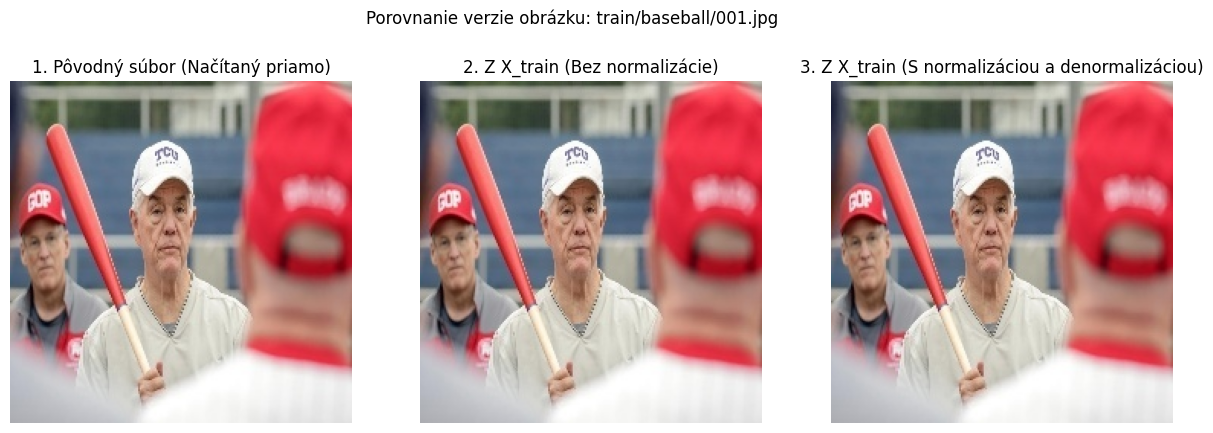

In [13]:
IMAGE_INDEX_TO_CHECK = 0
if len(X_train_unnormalized) == 0:
    print("Neboli načítané žiadne platné obrázky na porovnanie.")
else:
    original_df_index = valid_indices[IMAGE_INDEX_TO_CHECK]
    filepath_to_check = train_data.loc[original_df_index, "filepaths"]
    full_path_original = BASE + filepath_to_check

    #načítame pôvodný obrázok
    try:
        img_original_file = Image.open(full_path_original).convert("RGB").resize(TARGET_SIZE)
        img_original_file_array = np.asarray(img_original_file, dtype=np.uint8)

        #polia na zobrazenie a porovnanie
        #pole bez normalizácie (0-255 float -> uint8)
        img_unnormalized_array = X_train_unnormalized[IMAGE_INDEX_TO_CHECK].astype(np.uint8)
        #pole s normalizáciou (0-1 float -> denormalizácia -> uint8)
        img_normalized_denormalized_array = (X_train_normalized[IMAGE_INDEX_TO_CHECK] * 255).astype(np.uint8)

        #Vykreslenie všetkých troch obrázkov
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_original_file_array)
        axes[0].set_title("1. Pôvodný súbor (Načítaný priamo)")
        axes[0].axis('off')

        axes[1].imshow(img_unnormalized_array)
        axes[1].set_title("2. Z X_train (Bez normalizácie)")
        axes[1].axis('off')

        axes[2].imshow(img_normalized_denormalized_array)
        axes[2].set_title("3. Z X_train (S normalizáciou a denormalizáciou)")
        axes[2].axis('off')

        plt.suptitle(f"Porovnanie verzie obrázku: {filepath_to_check}")
        plt.show()
    except FileNotFoundError:
        print(f"Chyba: Súbor nenájdený na ceste: {full_path_original}. Skontroluj Base a subor")

Here we display effect of our selected augmentations, in this case altering brightness of the given picture or rotating image around its y-axis. At the end of this block of code are dispalyed of our pictures with chance of augmentation, also with label which tells us if the augmentation did happen with the selected image. We use these types of augmentation only on images stored in training part of our dataset.

Generovanie dokončené. Finálny tvar X_train: (1745, 224, 224, 3)


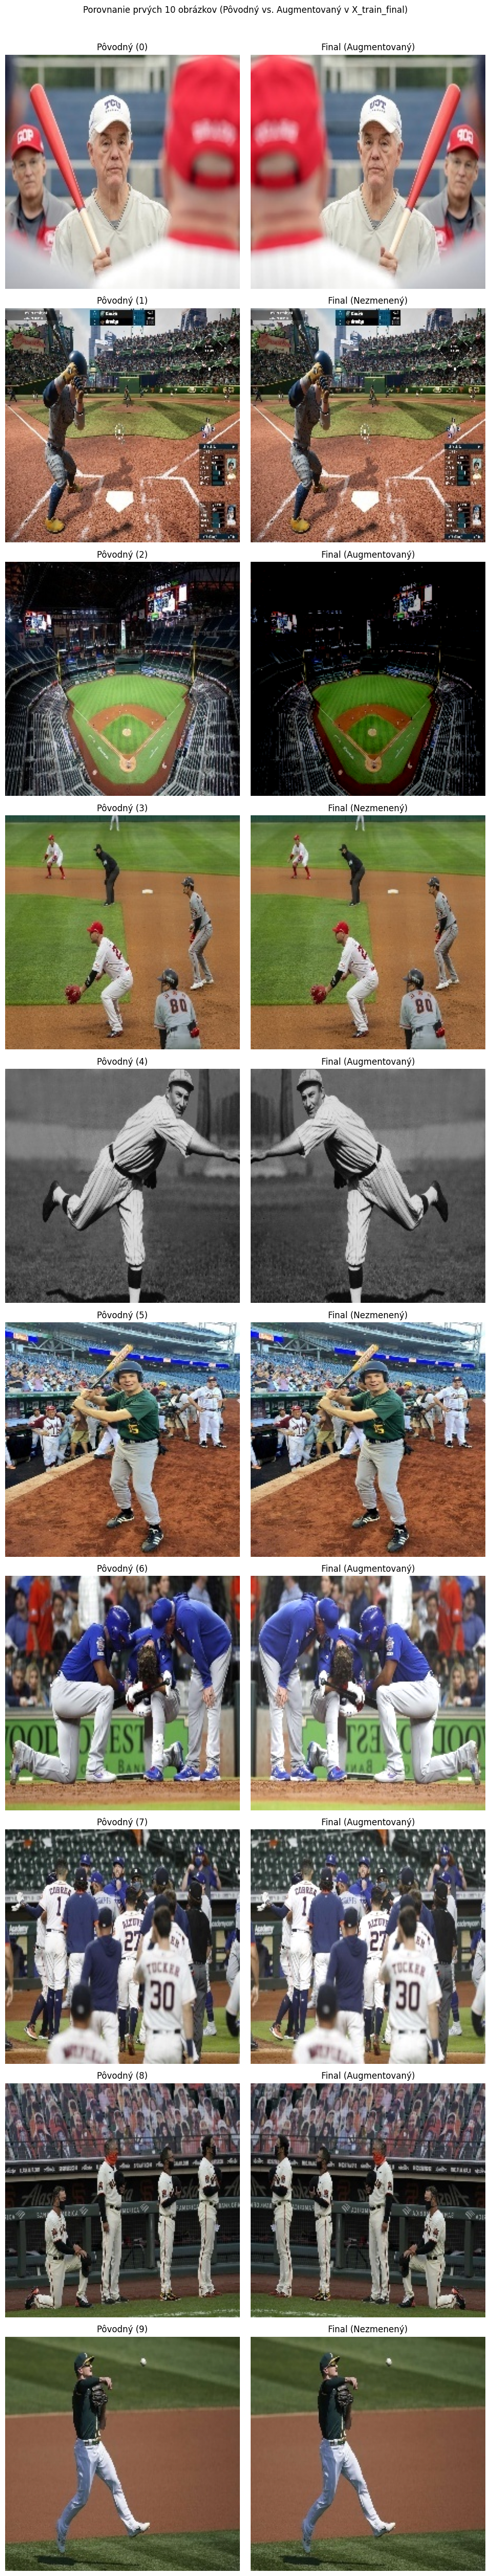

In [14]:
BRIGHTNESS_FACTOR = 0.4        #max rozsah jasu (napr. -0.4 až +0.4)
FLIP_PROBABILITY = 0.5
BRIGHTNESS_PROBABILITY = 0.5

def augment_image_for_training(image_array):
    #pouzijeme kopiu, aby sme neupravovali originál X_train_normalized
    augmented_image = image_array.copy()

    #zmena Jasu
    if random.random() < BRIGHTNESS_PROBABILITY:
        #nahodne vyberieme faktor jasu v rozsahu[-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR]
        brightness_delta = random.uniform(-BRIGHTNESS_FACTOR, BRIGHTNESS_FACTOR)
        augmented_image += brightness_delta
        #orezanie hodnot spat do rozsahu 0-1
        augmented_image = np.clip(augmented_image, 0.0, 1.0)

    # preklopenie okolo Y
    if random.random() < FLIP_PROBABILITY:
        augmented_image = np.flip(augmented_image, axis=1)

    return augmented_image

X_train_final_list = []
#ideme cez vsetky obrazky v normalizovanej sade
for i in range(X_train_normalized.shape[0]):
    #sanca na augmentaciu
    final_image = augment_image_for_training(X_train_normalized[i])
    X_train_final_list.append(final_image)

#pretvorime na filane numpy pole
X_train_final = np.array(X_train_final_list)

print(f"Generovanie dokončené. Finálny tvar X_train: {X_train_final.shape}")

#vykreslenie
NUM_IMAGES_TO_SHOW = 10

fig, axes = plt.subplots(NUM_IMAGES_TO_SHOW, 2, figsize=(10, 5 * NUM_IMAGES_TO_SHOW))
plt.suptitle(f"Porovnanie prvých {NUM_IMAGES_TO_SHOW} obrázkov (Pôvodný vs. Augmentovaný v X_train_final)", y=1.005)

#10 obrazkov
for i in range(NUM_IMAGES_TO_SHOW):

    #povodný obrazok
    original_image = X_train_normalized[i]

    #obrazok z novej sady X_train_final
    final_image = X_train_final[i]

    #denormalizacia na 0-255 uint8 pre zobrazenie
    original_display = (original_image * 255).astype(np.uint8)
    final_display = (final_image * 255).astype(np.uint8)

    # Vykreslenie pôvodného
    axes[i, 0].imshow(original_display)
    axes[i, 0].set_title(f"Pôvodný ({i})")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(final_display)

    #info ci sa image zmenil
    if np.array_equal(original_image, final_image):
        title = f"Final (Nezmenený)"
    else:
        title = f"Final (Augmentovaný)"

    axes[i, 1].set_title(title)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

---
Evaluation Matrics

Presnosť

Pomer správne klasifikovaných vzoriek k celkovému počtu vzoriek. Vhodná, ak sú všetky triedy dobre vyvážené (čo sme sa snažili dosiahnuť vyvážením "unknown" triedy).

Weighted F1-Score

Vhodna, ak sú triedy mierne nevyvážené alebo ak ti záleží na rovnomernom výkone vo všetkých triedach.

Presnosť (Precision) pre každú triedu

Z odpovedí pre danú triedu, koľko z nich bolo skutočne správnych. Ukazuje, ako často model robí falošne pozitívne predpovede pre túto triedu (napr. ako často označí "futbal" ako "neznámy").

Confusion Matrix

Nutna na zistenia ko moc sa model myli, porovnanie skutocne vysledko s ocakavanymi

In [15]:
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]
target_size = 224
batches = 64

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(TARGET_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(), # Converts image to a PyTorch Tensor
    transforms.Normalize(mean=normalization_mean, std=normalization_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalization_mean, std=normalization_std)
])

In [16]:
#Move to directory with custom classes
universal_input_path = "archive/"
universal_output_path = "custom_data/"
try:
    os.mkdir("custom_data/")
except FileExistsError:
    pass

folders = ["test/", "train/", "valid/"]

file_name = 1

for folder in folders:
    for cls in selected:
        try:
            os.mkdir(universal_output_path + cls)
        except FileExistsError:
            pass
        for item in os.listdir(universal_input_path + folder + cls.replace("_", " ")):
            if os.path.isfile(universal_input_path + folder + cls.replace("_", " ") + "/" + item):
                shutil.copyfile(universal_input_path + folder + cls.replace("_", " ") + "/" + item, universal_output_path + cls + "/" + str(file_name) + ".jpg")
                file_name += 1
            else:
                print(os.path.join(universal_input_path + folder + cls.replace("_", " ") + "/" + item)) #Ďiebug prinť



In [17]:
input_folder = "custom_data"
output_folder = "custom_data_split"

splitfolders.ratio(
    input_folder,
    output_folder,
    seed=10313,
    ratio=(0.7, 0.1, 0.2),
    group_prefix=None,
    move=False,
)

Unfortunately, we are working with small sample of images (less then 2000 for all purposes - train, test and validation), which really is not enough so we double the number if images suing augmentations. We have picked several types of them so the newly created images are not as similar to their "parent" versions, and will be used to train, test and validate how good our classifier works. SOme of our augmentations (image rotation and brightness settings (ColorJitter)) apply every time, but other such as horizontal flip or crop have only chance of happening. We hope this will provide us with new adn unique versions of used images.

In [18]:
#moja verzia augemntacii
'''
import os
from PIL import Image
import random
from torchvision import transforms

BASE_PATH = "custom_data_split/"
folders = ["train", "test", "val"]

augmentations = transforms.Compose([

    # always apply
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
    ),

    # can apply

    # 50% chance - otocit okolo y
    transforms.RandomHorizontalFlip(p=0.5),

    # 40% chance - crop
    transforms.RandomApply(
        [transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0))],
        p=0.4
    ),

    # 30% chance - blur
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=3)],
        p=0.3
    ),

    # FINAL RESIZE
    transforms.Resize((224, 224)),
])


def augment_image(image_path):
    """Open image, create augmented copy, save next to original."""
    img = Image.open(image_path).convert("RGB")

    # apply our augmentation
    aug = augmentations(img)

    # new filename
    dir_path = os.path.dirname(image_path)
    base_name = os.path.basename(image_path)
    name_no_ext, ext = os.path.splitext(base_name)

    new_filename = f"{name_no_ext}_aug{ext}"
    new_path = os.path.join(dir_path, new_filename)

    aug.save(new_path)



for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            try:
                augment_image(img_path)
            except Exception as e:
                print(f"Error augmenting {img_path}: {e}")
'''

'\nimport os\nfrom PIL import Image\nimport random\nfrom torchvision import transforms\n\nBASE_PATH = "custom_data_split/"\nfolders = ["train", "test", "val"]\n\naugmentations = transforms.Compose([\n\n    # always apply\n    transforms.RandomRotation(25),\n    transforms.ColorJitter(\n        brightness=0.3,\n        contrast=0.3,\n        saturation=0.3,\n    ),\n\n    # can apply\n\n    # 50% chance - otocit okolo y\n    transforms.RandomHorizontalFlip(p=0.5),\n\n    # 40% chance - crop\n    transforms.RandomApply(\n        [transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0))],\n        p=0.4\n    ),\n\n    # 30% chance - blur\n    transforms.RandomApply(\n        [transforms.GaussianBlur(kernel_size=3)],\n        p=0.3\n    ),\n\n    # FINAL RESIZE\n    transforms.Resize((224, 224)),\n])\n\n\ndef augment_image(image_path):\n    """Open image, create augmented copy, save next to original."""\n    img = Image.open(image_path).convert("RGB")\n\n    # apply our augmentation\n    a

In [19]:

#Matus old kod
import os
from PIL import Image
import random
from torchvision import transforms

BASE_PATH = "custom_data_split/"
folders = ["test", "train", "val"] #I (Matúš Šikyňa) was too lazy to fix this properly. In my defense, have you seen TF2 code?

# ----------------------------
# Augmentations (rich & varied)
# ----------------------------
augmentations = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(25),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
    ]),
    transforms.Resize((224, 224)),
])

def augment_image(image_path):
    """Open image, create augmented copy, save next to original."""
    img = Image.open(image_path).convert("RGB")

    # Apply augmentation
    aug = augmentations(img)

    # New filename
    dir_path = os.path.dirname(image_path)
    base_name = os.path.basename(image_path)
    name_no_ext, ext = os.path.splitext(base_name)

    new_filename = f"{name_no_ext}_aug{ext}"
    new_path = os.path.join(dir_path, new_filename)

    aug.save(new_path)


# ----------------------------
# Process all images
# ----------------------------
for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)

        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            try:
                augment_image(img_path)
            except Exception as e:
                print(f"Error augmenting {img_path}: {e}")



In [20]:
# input_folder = "custom_data"
# output_folder = "custom_data_split"
#
# splitfolders.ratio(
#     input_folder,
#     output_folder,
#     seed=10313,
#     ratio=(0.7, 0.1, 0.2),
#     group_prefix=None,
#     move=False,
# )

In [21]:
BASE_PATH = "custom_data_split/" # Adjust this path as needed

# 1. Create Datasets
train_dataset = ImageFolder(root=BASE_PATH + "train", transform=train_transforms)
val_dataset = ImageFolder(root=BASE_PATH + "val", transform=val_test_transforms)
test_dataset = ImageFolder(root=BASE_PATH + "test", transform=val_test_transforms)

# 2. Create DataLoaders
# Setting num_workers to 4-8 is usually optimal for modern CPUs
train_loader = DataLoader(train_dataset, batch_size=batches, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batches, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batches, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Number of classes detected: {num_classes}") # Should be 10
print(f"Training images: {len(train_dataset)}") # Should be ~1745


Number of classes detected: 10
Training images: 2574


Following code containing class defines a BasicBlock, one of the fundamental components of ResNet. The block processes the input through two convolutional layers, and each of them is followed by batch normalization, which helps stabilize training by keeping activations well-scaled. Between the two convolutions, a ReLU activation is applied to introduce non-linearity. At the same time, the original input is stored as a shortcut connection. If the size or number of channels changes—because of a different stride or output depth—the shortcut is passed through a simple 1×1 convolution (also followed by batch normalization) to make the shapes compatible. Finally, the output of the convolutional path is added to the shortcut, and a last ReLU is applied. This skip-connection design, combined with normalization, helps the network train deeper models more reliably and prevents issues like vanishing gradients.

In [22]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer in the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer in the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection (1x1 conv if input/output dimensions change)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x # Store input for the skip connection

        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # H(x) = F(x) + x
        out += self.shortcut(identity)
        out = self.relu(out) # Final ReLU for the block
        return out

This class defines a lightweight custom version of ResNet. It starts with a standard convolutional “stem” (7×7 conv + batch normalization + ReLU + max-pool), which reduces the image size and prepares the feature maps for deeper layers. The main part of the network is made of three residual stages, each created by stacking BasicBlocks. The first block in a stage may downsample the feature maps (using a higher stride), and each block includes batch normalization to keep the feature values stable during training.

After the residual layers, the model switches to the classification head. A global average pooling layer squeezes each feature map down to a single value. The result is flattened, passed through a linear layer, regularized with dropout, and finally sent to the last fully connected layer that outputs the raw class scores. Softmax isn’t applied here because PyTorch’s CrossEntropyLoss handles that automatically. The whole design keeps the core ideas of ResNet—skip connections and normalization—while staying compact and fast to train.

In [23]:
class CustomResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64 # Starting channel depth

        # 1. Initial Block (Feature Map Reduction)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 2. Residual Stages (Defining the Minimal ResNet-9/18 Structure)
        # num_blocks should be a list like [2, 2, 2]
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # Downsample here
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # Downsample here

        # 3. Classification Head (Minimalist & Regularized)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling (GAP)
        self.flatten = nn.Flatten()

        # The final input size is 256 (from layer3 output channels) * 1 (expansion)
        self.linear1 = nn.Linear(256 * block.expansion, 64 * block.expansion)
        self.dropout = nn.Dropout(p=0.5) # Aggressive Dropout
        self.linear2 = nn.Linear(64 * block.expansion, num_classes) # Final linear layer

    # Helper function to stack blocks
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride_val in strides:
            layers.append(block(self.in_channels, out_channels, stride_val))
            self.in_channels = out_channels * block.expansion # Update current channel count
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual Stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Classification Head
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x) # Apply Dropout before the final layer
        x = self.linear2(x) # Output logits (no Softmax here, CrossEntropyLoss applies it)
        return x

# Instantiate the model with a minimal ResNet structure (e.g., ResNet-9)
# [2, 2, 2] means 2 blocks in each of the three residual stages.
model = CustomResNet(BasicBlock, [2, 2, 2], num_classes=num_classes)

Here we can change values of hyperparameters such as learning rate, number of epochs we want our classifier to run and patience. Patience tells us how long should the code run if the results we are getting are noot really changing - the difference is too insignificant patience number of epochs in a row.

In [24]:


# 1. Device Setup (GPU)
model = model.to(device)

# 2. Loss Function
# nn.CrossEntropyLoss is used for multi-class classification and expects RAW LOGITS
# (no Softmax on the model output) and integer class labels (not one-hot).
criterion = nn.CrossEntropyLoss()

# 3. Optimizer with L2 Weight Decay (Anti-Overfitting)
# weight_decay implements L2 regularization. Small learning rate (1e-4) is conservative.
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 4. Learning Rate Scheduler
# Reduces the learning rate by 0.1 if validation loss doesn't improve for 5 epochs.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# 5. Training Control
EPOCHS = 5 # Set a generous number of epochs, relying on Early Stopping
PATIENCE = 10 # Early stopping patience

Here we do the testing itself. We feed our classifier training data followed by data from validation folder. We repeat this proces number of epochs time, in hopes that model will be able to generalize the data is sees, and we can observe that during run time with accuracy and loss prints in provides after every epoch with testing and validation data. At the end after number of epochs we feed model "unseen" training data ro see how it reacts and if we get good results and they arent too dfferent with the ones from training and validation data we got during our model "learning" runs, we can safely say that the model works as it should.

In [25]:
# Function to calculate accuracy
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    model.eval() # Set model to evaluation mode (turns off dropout/BN tracking)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) # Get the index of max logit
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train() # Set model back to training mode
    return correct / total
'''
import wandb
wandb.init(
    project="resnet_training_project",
    config={
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "epochs": EPOCHS,
        "patience": PATIENCE,
        "dropout": 0.3,
        "model": "CustomResNet"
    }
)
'''

# --- Training Loop ---
best_val_loss = np.inf
patience_counter = 0

for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    train_loss = 0.0

    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Validation step
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    # Calculate average losses and metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_accuracy = calculate_accuracy(train_loader, model, device)
    val_accuracy = calculate_accuracy(val_loader, model, device)

    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')

    '''
    wandb.log({
    "Train Loss": train_loss,
    "Validation Loss": val_loss,
    "Train Accuracy": train_accuracy,
    "Validation Accuracy": val_accuracy,
    "Learning Rate": optimizer.param_groups[0]['lr']
    })
    '''
    # Learning Rate Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the BEST model weights
        torch.save(model.state_dict(), 'best_custom_resnet.pth')
        print("Model saved! (New best validation loss)")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print(f"--- Early stopping triggered after {epoch+1} epochs ---")
            break

# --- Final Evaluation ---
model.load_state_dict(torch.load('best_custom_resnet.pth')) # Load best weights
test_accuracy = calculate_accuracy(test_loader, model, device)

# Final Test Loss calculation (optional, but good practice)
test_loss = 0.0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
'''
wandb.log({
    "Test Loss": test_loss,
    "Test Accuracy": test_accuracy
})

wandb.finish()
'''

print("\n--- FINAL RESULTS ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/5 | Train Loss: 1.8809 | Train Acc: 0.3796 | Val Loss: 1.7835 | Val Acc: 0.3806
Model saved! (New best validation loss)
Epoch 2/5 | Train Loss: 1.4061 | Train Acc: 0.5210 | Val Loss: 1.4174 | Val Acc: 0.4806
Model saved! (New best validation loss)
Epoch 3/5 | Train Loss: 1.2284 | Train Acc: 0.5796 | Val Loss: 1.3239 | Val Acc: 0.5278
Model saved! (New best validation loss)
Epoch 4/5 | Train Loss: 1.0782 | Train Acc: 0.5229 | Val Loss: 1.4849 | Val Acc: 0.5278
Patience: 1/10
Epoch 5/5 | Train Loss: 1.0419 | Train Acc: 0.7059 | Val Loss: 1.0865 | Val Acc: 0.6444
Model saved! (New best validation loss)

--- FINAL RESULTS ---
Test Loss: 0.9652
Test Accuracy: 0.6759


In [26]:
def evaluate_metrics(loader, model, device, num_classes=10):
    all_preds = []
    all_labels = []
    all_probas = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities for mAP calculation
            probas = F.softmax(outputs, dim=1).cpu().numpy()
            all_probas.extend(probas)

            # Get predictions and labels for confusion matrix/P&R/F1
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probas = np.array(all_probas)

    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 2. Precision, Recall, F1-Score, Support (Per Class)
    # The 'None' value for 'support' is an optional return from the function
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average=None # Calculates metrics for EACH class separately
    )

    # 3. Mean Average Precision (mAP)
    # The AUC of the Precision-Recall curve, averaged over all classes.
    # Note: 'average_precision_score' in sklearn is AUC-PR, often used synonymously with mAP.
    # Requires true one-hot labels for computation.

    # Convert integer labels to one-hot encoding
    all_labels_one_hot = np.zeros((len(all_labels), num_classes))
    all_labels_one_hot[np.arange(len(all_labels)), all_labels] = 1

    # Calculate Average Precision for each class
    ap_per_class = []
    for i in range(num_classes):
        ap = average_precision_score(all_labels_one_hot[:, i], all_probas[:, i])
        ap_per_class.append(ap)

    mAP = np.mean(ap_per_class) # Mean of Average Precision

    # 4. Overall Macro-Averages for P, R, F1 (useful for summarizing)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)

    return {
        'confusion_matrix': cm,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1_score,
        'mAP': mAP,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
    }

In [27]:
# --- Final Evaluation ---
model.load_state_dict(torch.load('best_custom_resnet.pth')) # Load best weights

# Call the enhanced evaluation function
metrics = evaluate_metrics(test_loader, model, device, num_classes=num_classes)

# Get the list of class names from the dataset
class_names = test_loader.dataset.classes

print("\n--- DETAILED TEST SET RESULTS ---")

## A. Overall Averages
print(f"Macro Average Precision: {metrics['macro_precision']:.4f}")
print(f"Macro Average Recall:    {metrics['macro_recall']:.4f}")
print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")

## B. Per-Class Metrics
print("\n--- Per-Class Metrics ---")
print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
print("-" * 45)
for i in range(num_classes):
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        class_names[i],
        metrics['precision_per_class'][i],
        metrics['recall_per_class'][i],
        metrics['f1_per_class'][i]
    ))

## C. Confusion Matrix
print("\n--- Confusion Matrix (True Label vs. Predicted Label) ---")
print("Labels (rows/cols):", class_names)
print(metrics['confusion_matrix'])


--- DETAILED TEST SET RESULTS ---
Macro Average Precision: 0.7062
Macro Average Recall:    0.6790
Mean Average Precision (mAP): 0.7584

--- Per-Class Metrics ---
Class           Precision  Recall     F1-Score  
---------------------------------------------
baseball        0.5741     0.4079     0.4769    
basketball      0.5568     0.6622     0.6049    
canoe_slamon    0.6768     0.9306     0.7836    
football        0.5463     0.7195     0.6211    
formula_1_racing 0.6875     0.6875     0.6875    
hockey          0.8793     0.6892     0.7727    
nascar_racing   0.8103     0.5732     0.6714    
olympic_wrestling 0.9375     0.6081     0.7377    
roller_derby    0.5818     0.9143     0.7111    
rugby           0.8113     0.5972     0.6880    

--- Confusion Matrix (True Label vs. Predicted Label) ---
Labels (rows/cols): ['baseball', 'basketball', 'canoe_slamon', 'football', 'formula_1_racing', 'hockey', 'nascar_racing', 'olympic_wrestling', 'roller_derby', 'rugby']
[[31  8  9 19  0  1  0